In [1]:
#Installing all dependencies

import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import scale
from numpy import pi, sqrt
import math
import random
from scipy.optimize import minimize

import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

**Table of Contents**

**Part 1: Theory**

1. <a href="#1">The Variational Quantum Eigensolver</a>
2. <a href="#2">The Quantum Approximate Optimization Algorithm</a>
3. <a href="#3">Continuous-Variable QAOA</a>

**Part 2: Simulations**

4. <a href="#4">A Small Tangent: Creating Quadrature Plots With Strawberry Fields and Matplotlib</a>
5. <a href="#5">Simulating Continuous-Variable QAOA For a Simple Problem</a>
6. <a href="#6">Simulating Continuous-Variable QAOA For Harder Problems</a>
7. <a href="#7">The Not-So Grand Finale: A Quartic Function With Two Global Minima</a>
8. <a href="#8">Another Small Tangent: Higher-Order Gate Decomposition</a>
9. <a href="#9">I Promise This is Our Last Detour: Numerically Calculating the Cost Hamiltonian Expectation Value</a>
<br><br>
10. <a href="#10">Conclusion</a>
11. <a href="#11">Acknowledgments and References</a>


<br>

**The Variational Quantum Eigensolver** <div id="1"></div>

The reason that VQE works is because of an idea within quantum mechanics called the **variational principle**, which states that if I have some Hamiltonian describing a quantum system, and I choose some state vector $|\psi\rangle$, then:

<br><br>

$$\langle \psi | H | \psi \rangle \ \geq \ E_0$$

<br><br>

Where $E_0$ is the ground-state energy. The proof of this is fairly straightforward. Any state vector $|\psi\rangle$ can be expressed as a linear combination of energy eigenstates:

<br><br>

$$|\psi\rangle \ = \ \displaystyle\sum_{n} \ c_n |E_n\rangle$$

<br><br>

So we then have:

<br><br>

$$\langle \psi | H | \psi \rangle \ = \ \Bigg( \displaystyle\sum_{n} \ c_n^* \langle E_n| \Bigg) H \Bigg( \displaystyle\sum_{n} \ c_n | E_n \rangle \Bigg) \ = \ \Bigg( \displaystyle\sum_{n} \ c_n^* \langle E_n| \Bigg) \Bigg( \displaystyle\sum_{n} \ c_n H | E_n \rangle \Bigg) \ = \ \Bigg( \displaystyle\sum_{n} \ c_n^* \langle E_n| \Bigg) \Bigg( \displaystyle\sum_{n} \ c_n E_n | E_n \rangle \Bigg)$$ 

<br><br>

$$\Rightarrow \ \Bigg( \displaystyle\sum_{n} \ c_n^* \langle E_n| \Bigg) \Bigg( \displaystyle\sum_{n} \ c_n E_n | E_n \rangle \Bigg) \ = \ \displaystyle\sum_{n} \ |c_n|^2 \ E_n$$

<br><br>

And so, it follows that the minimum possible energy for the this sum is when $|c_0|^2 \ = \ 1$ and the rest of the coefficients equal $0$ (because of the normalization condition). This is the ground state energy, so it follows that:

<br><br>

$$E_0 \ \leq \ \displaystyle\sum_{n} \ |c_n|^2 \ E_n \ = \ \langle \psi | H | \psi \rangle$$

<br><br>

This is super cool! This bascially means that if I have some Hamiltonian, I can pick any quantum state I want and the expectation value of the Hamiltonian corresponding to this state will **always** be greater than or equal to the ground state energy. Now, let's say that I have some optimization problem, which I must solve by minimizing some cost function. Well, if I can write this cost function as a Hamiltonian that acts on quantum states, then, I can create a process in which I guess an initial wavefunction, calculate the expectation value of the Hamiltonian, then pass that result through a classical optimizer and continue to vary the parameters of the initial wavefunction until I find the lowest energy state, corresponding to $E_0$. The variational principle tells me that I can never "wrongly guess" a wavefunction: I can't choose a wavefunction that corresponds to an expected energy below the ground state, thus throwing off my optimization process.

**The Quantum Apprroximate Optimization Algorithm** <div id="2"></div>

QAOA is a quantum optimization algorithm where a quantum state is recursively evolved to some state, corresponding to the optimal state of some Hamiltonian. The total evolution of the state through QAOA is given as:

<br><br>
$$|s\rangle \ \rightarrow \ |s'\rangle \ = \ \textbf{U} |s\rangle \ = \ \displaystyle\prod_{k} \ U(\gamma_k, \ \alpha_k) |s\rangle \ \ \ \ \ \ \gamma_k \ \in \ \boldsymbol \gamma, \ \ \alpha_k \ \in \ \boldsymbol \alpha \ \ \ \forall k$$
<br><br>

Where $\boldsymbol \gamma$ and $\boldsymbol \alpha$ are sets of parameters used for our run of the algorithm. We are able to set the value of $k$, with $k \ \rightarrow \ \infty$ theoretically leading to $\epsilon \ \rightarrow \ 0$, hwoever, this is not the case in reality, as increasing circuit depth increases error, so it is up to the individual utilizing the algorithm to "turn the knobs" to set $k$ to a value that gives error below a desired threshold, while also keeping in mind quantum hardware limitations and noise.

Since this is a variational algorithm, a classical optimizer will optimize our $\gamma$ and $\alpha$ parameters over repeated runs of the circuit, until we converge on parameters that yield a state, which, when measured, yields the lowest value of the cost function.

You may be wondering now why QAOA actually makes sense as an "ansatz strategy". Basically, we have some cost function that we want to minimize, which we express as a Hamiltonian acting on quantum state vectors, called $H_{C}$. Well, there is no guarentee that our Hamiltonian $H_{C}$ is unitary (and can thus represent a quantum gate operation). However, it is true that an operator of the form $e^{ikH}$ is unitary. In fact, recall from quantum mechanics the time-dependent Schrödinger equation:

<br><br>
$$i\hbar \frac{d |\Psi(t)\rangle}{dt} \ = \ \hat{H} |\Psi(t)\rangle \ \Rightarrow \ i\hbar \frac{d}{dt} \displaystyle\sum \ c_n(t) |E_n\rangle \ = \ \hat{H} \ \displaystyle\sum c_n(t) |E_n\rangle$$
<br><br>

Where we also have:

<br><br>
$$\hat{H} |E_n\rangle \ = \ E_n |E_n\rangle \ \ \forall \ n$$
<br><br>

Expanding in this basis yields uncoupled differential equation describing the components $c_n(t)$, which we then solve to get the generaal time-dependence of energy eigenstates:

<br><br>
$$\hat{H} \ \displaystyle\sum c_n(t) |E_n\rangle \ = \ \displaystyle\sum c_n(t) E_n |E_n\rangle \ \Rightarrow \ i\hbar \frac{d c_n(t)}{dt} \ = \ c_n(t) E_n \ \Rightarrow \ c_n(t) \ = \ c_n(0) e^{-iE_n t/\hbar}$$
<br><br>

But, we also have:

<br><br>
$$|\Psi(0)\rangle \ = \ \displaystyle\sum c_n(0) |E_n\rangle \ \Rightarrow \ c_k(0) \ = \ \langle E_k | \Psi(0) \rangle$$
<br><br>

Putting this all together, we have:

<br><br>
$$|\Psi(t)\rangle \ = \ \displaystyle\sum e^{-iE_n t/\hbar} \langle E_n | \Psi(0) \rangle |E_n\rangle \ = \ \Big( \displaystyle\sum e^{-iE_n t/\hbar} | E_n \rangle \langle E_n | \Big) |\Psi(0)\rangle$$
<br><br>

So, since the $|E_n\rangle$ states form a complete basis, we have:

<br><br>
$$\Big( \displaystyle\sum |E_n\rangle \langle E_n| \Big) \ = \ \mathbb{I}$$
<br><br>

We can exploit this, but we first have to deal with the exponential. It turns out, we have:

<br><br>
$$\Big( \displaystyle\sum e^{-iE_n t/\hbar} | E_n \rangle \langle E_n | \Big) |\Psi(0)\rangle \ = \ e^{-i\hat{H} t/\hbar} \mathbb{I} |\Psi(0)\rangle \ = \ e^{-i\hat{H} t/\hbar} |\Psi(0)\rangle$$
<br><br>

Which we can easily show:

<br><br>
$$e^{-i\hat{H} t/\hbar} |\Psi(0)\rangle \ = \ \displaystyle\sum c_n(0) e^{-i\hat{H} t/\hbar} |E_n\rangle \ = \ \displaystyle\sum c_n(0) \displaystyle\sum_{k \ = \ 0}^{\infty} \frac{(-it/\hbar)^k \hat{H}^k}{k!} |E_n\rangle \ = \ \displaystyle\sum c_n(0) \displaystyle\sum_{k \ = \ 0}^{\infty} \frac{(-it/\hbar)^k E_n^k}{k!} |E_n\rangle$$
<br>
$$\Rightarrow \displaystyle\sum c_n(0) e^{-iE_n t/\hbar} |E_n\rangle \ = \ \Big( \displaystyle\sum e^{-iE_n t/\hbar} | E_n \rangle \langle E_n | \Big) |\Psi(0)\rangle$$
<br><br>

So we have a unitary called $U$, which we call the time-evolution operator, as it performs the transformation:

<br><br>
$$|\Psi(0)\rangle \ \rightarrow \ |\Psi(t)\rangle \ = \ U |\Psi(0)\rangle \ \Rightarrow \ U \ = \ e^{-i\hat{H} t/\hbar}$$
<br><br>

Well, this looks awfully similar to the parametrized unitaries that we use for QAOA, $e^{-i\gamma H_{C}}$ and $e^{-i \alpha H_{M}}$! This is no coincidence! The idea with QAOA is that we evolve our state in "time" to the ground state of our cost Hamiltonian. In order for this idea to fully make sense, we need to discuss quantum adiabatic evolution. Consider the Hamiltonian that evolves in time due to some continuously applied perturbation:

<br><br>
$$\hat{H}(t) \ = \ \frac{t}{T} \hat{H}_{C} \ + \ \Big(1 \ - \ \frac{t}{T} \Big) \hat{H}_{M}$$
<br><br>

The idea is that if we have some quantum system that starts (at $t \ = \ 0$) in the ground state of some mixer Hamiltonian $\hat{H}_M$, and we slowly evolve the Hamiltonian over time, then the evolution of our quantum state will tend towards the ground state of the new, cost Hamiltonian $\hat{H}_{C}$. This is formally known as the **quantum adiabatic theorem**. The parameter $T$ allows us to control how quickly we evolve from $\hat{H}_{M}$ to $\hat{H}_{C}$. Theoretically, as $T \ \rightarrow \ \infty$, our state approaches the ground state of $\hat{H}_{C}$ with probability of $1$. For QAOA, we are basically utilizing a discrete version of this process. We start our qubit state in the ground state of $\hat{H}_M$, which we call $|M_0\rangle$.

Now, things are going to get a bit hairy. Time-evolution according to as time-dependent Hamiltonian is different than a time-independent one. We must use something called a **Dyson Series** which I won't go into in this article to arrive at the fact that between $t_1$ and $t_2$, the time-evolution operator is given as:

<br><br>
$$U(t_1, \ t_2) \ = \ \tau \exp \Big( -\frac{i}{\hbar} \displaystyle\int_{t_1}^{t_2} H(t) dt \Big)$$
<br><br>

Well, let's compute this integral and see what happens!

<br><br>
$$\displaystyle\int_{t_1}^{t_2} H(t) dt \ = \ \displaystyle\int_{t_1}^{t_2} \frac{t}{T} \hat{H}_{C} \ + \ \Big(1 \ - \ \frac{t}{T} \Big) \hat{H}_{M} dt \ = \ \frac{t^2}{2T} \hat{H}_{C} \ - \ \frac{T}{2} \Big(1 \ - \ \frac{t}{T} \Big)^2 \hat{H}_{M} \biggr\rvert_{t_1}^{t_2}$$
<br><br>

We are evolving our quantum system from $t \ = \ 0$ to $t \ = \ T$, so we have:

<br><br>
$$\frac{t^2}{2T} \hat{H}_{C} \ - \ \frac{T}{2} \Big(1 \ - \ \frac{t}{T} \Big)^2 \hat{H}_{M} \biggr\rvert_{0}^{T} \ = \ \frac{T}{2} (\hat{H}_{M} \ + \ \hat{H}_{C} )$$
<br><br>

Since we are not dealing with products of operators, the time-ordering operator $\tau$ drops away. So the time-evolution of our quantum state from $t \ = \ 0$ to $t \ = \ T$ is given as:

<br><br>
$$|M_0\rangle \ \rightarrow \ U |M_0\rangle \ = \ e^{-iT (\hat{H}_{M} \ + \ \hat{H}_{C})/2\hbar} |M_0\rangle$$
<br><br>

In order to realize this operator on a quantum circuit, we have to Trotterize it. When I say Trotterize, I mean we have to perform a Trotter-Suzuki decomposition, which says that:

<br><br>
$$e^{i t \sum H_k} \ \approx \ \Big ( \displaystyle\prod_k e^{i \frac{t}{G} H_k} \Big)^{G}$$
<br><br>

Where the approximation gets better as $G$ increases. This equates to an increased number of steps in our algorithm (applications of $U(\gamma, \ \alpha)$)! From this, we have:

<br><br>
$$e^{-iT (\hat{H}_{M} \ + \ \hat{H}_{C})/2\hbar} \ = \ \Big( e^{-i\frac{T}{2G\hbar} \hat{H}_{M}} e^{-i\frac{T}{2G\hbar} \hat{H}_{C}} \Big)^{G}$$
<br><br>

Now, we have a nice ansatz that should evolve our quantum state to the ground state of $\hat{H}_{C}$. However, where do the parameters $\alpha$ and $\gamma$ come into play? Since the Trotter-Suzuki decomposition is not exact (the exact form of the expansion of the exponential is given by the Baker-Campbell-Hausdorff formula, which is an infinite product of commutators of the operators in the exponential), and we are limited to a finite value of $G$ (actually, $G$ has to be pretty small to keep circuit depth low). In addition, we can't always initialize our system in the ground state of the mixer Hamiltonian, as often, strategies are utilized where the mixer's purpose is to "search" the space of feasible solutions or encode hard-constraints. In these cases, the initial state is often set to overlap many possible states/states that obey the hard-constraints. This means that we need to introduce another degree (or degrees plural) of freedom to our state preparation circuit, in order to get the acceptable results. Thus, we **parametrize** our exponential operators with the sets $\boldsymbol \alpha$ and $\boldsymbol \gamma$, where $|\boldsymbol \gamma| \ = \ |\boldsymbol \alpha| \ = \ G$.

The final evolution of our state after applying the QAOA ansatz is given as:

<br><br>
$$|M_0\rangle \ \rightarrow \ \Big( e^{-i \alpha H_{M}} e^{-i \gamma H_{C}} \Big)^{G} |M_0\rangle \ \approx \ |C_0\rangle$$
<br><br>

So if we have done everything correct, we should get a state that is approximately the ground state of our cost Hamiltonian, which is exactly the problem we are attempting to solve!

Now consider what happens when we take a measurement of the quantum state we have preparred, which you should recall is denoted as $|s'\rangle \ = \ \textbf{U} |s\rangle$. Now that we have preparred our quantum state (as one does in a variational algorithm), we must calculate $\langle s' | H_{C} | s'\rangle$. 

To do this we sample our circuit repeatedly, measuring in the basis of energy eigenstates of $H_{C}$. In most cases, for the discrete QAOA, we express our cost function with $\sigma^z$ operators, so this ends up being the standard computational basis. In CV QAOA, we will soon show that our cost functions are expressed in terms of $\hat{x}$ operations, so we take an X-Homodyne measurement. 

From measurement, we obtain a result $|k\rangle$, and we then feed the value associated with $|k\rangle$, which we will call $k$, into our classical cost function, and after many samples of the circuit, take the average of the sum of all outputs of the cost function. If we sample the circuit $N$ times, we get the quantity:

<br><br>
$$\frac{1}{N} \displaystyle\sum_{i} n_i E_i \ \approx \ \displaystyle\sum_{i} \text{Pr} (E_i) E_i \ = \ \displaystyle\sum_{i} \langle s' | E_i \rangle \langle E_i | s' \rangle E_i \ = \ \langle s' | \Big( \displaystyle\sum_{i} E_i |E_i\rangle \langle E_i| \Big) | s' \rangle \ = \ \langle s' | \Big( \displaystyle\sum_{i} \hat{H}_{C} |E_i\rangle \langle E_i| \Big) | s' \rangle$$
<br>
$$\Rightarrow \ \langle s' | \hat{H}_{C} \Big( \displaystyle\sum_{i} |E_i\rangle \langle E_i| \Big) | s' \rangle \ = \ \langle s' | \hat{H}_{C} | s' \rangle$$
<br><br>

Where $n_i$ is the number of time $|E_i\rangle$ is measured. So we have proven that our method of calculating the cost function is valid, as the quantity that we calculate by sampling our circuit is equivalent to $\langle s' | H_{C} | s' \rangle$! The same kind of logic applies for continuous spectra of energy, but we are approximating the integral over all possible values with a Reimann sum. 

**Continuous-Variable QAOA** <div id="3"></div>

This is going to be the collest section of the Notebook (in my opinion), because despite being short, we will get some more intuition as to why the **continuous-variable analogue** of QAOA actually works! Of course, the method that we outlined in the previous section generalizes well to a continuous or discrete qudit model, however, the introduction in the paper provides even more intuition as to why this method works!

In order to create QAOA over continuous-variables, we follow the same process of creating a mixer and a cost Hamiltonian. For the cost unitary, we will initilize our cost Hamiltonian (the unitary is given by the imaginary exponential) by creating a **function with respect to the position quadrature**, which is just the observable operator that corresponds to "position" (well, not actually position, a qumode doesn't actually "move around" like a particle in some potential, but it behaves pretty much identically to how the position operator behaves when acted upon by other operators in the Heisenberg picture. In reality, the two quadratures that we use in photonic QC represent in-phase and out-of-phase components of an electric field). Anyways, if we have some scalar function, we will transform it as $f(x) \ \rightarrow  \ f(\hat{x})$. For example, $f(x) \ = \ x^3 \ \rightarrow \ f(\hat{x}) \ = \ \hat{x}^3$. Our cost unitary then looks something like this:

<br><br>
$$U_C \ = \ e^{i \gamma f(\hat{x})}$$
<br><br>

Where $f(x)$ is the actual cost function that we are trying to minimize.

In order to implement continuous-variable QAOA, we follow the same general process as the discrete version of QAOA. We choose a cost and a mixer Hamiltonian, which we then Trotterize and recurrsivley act upon our photonic modes. For each step of the algorithm, we write the unitary as:

<br><br>
$$U(\gamma, \ \alpha) \ = \ e^{-i \alpha \hat{H}_M} e^{-i\gamma \hat{H}_C}$$
<br><br>

For our mixer, we are required to define our mixer Hamiltonian. Let's first consider a mixer which we will call the **kinetic mixer**, defined by the Hamiltonian, and thus the unitary:

<br><br>
$$H_{K} \ = \ \frac{1}{2} \displaystyle\sum_{i} \hat{p}^2_i \ \Rightarrow \ U_{K} \ = \ e^{-i \alpha \frac{1}{2}\hat{p^2}}$$
<br><br>

Where the sum over all modes is implied in the exponential. Consider how an application of this gate transforms our $\hat{x}$ operator, if we consider evolution of quantum states in terms of the Heisenberg picture, where quantum states remain fixed, but the operators themselves evolve:

<br><br>
$$e^{i \alpha \frac{1}{2} \hat{p}^2} \ = \ e^{i \alpha \frac{1}{2} (p \mathbb{I})^2} \ = \displaystyle\sum_{n \ = \ 0}^{\infty} \Big( \frac{i \alpha}{2} \Big)^n \frac{(p \mathbb{I})^{2n}}{n!} \ = \ \mathbb{I} \displaystyle\sum_{n \ = \ 0}^{\infty} \Big( \frac{i \alpha}{2} \Big)^n \frac{p^{2n}}{n!} \ = \ \mathbb{I} e^{i \alpha \frac{1}{2} \hat{p}^2}$$
<br><br>
$$e^{i \alpha \frac{1}{2} \hat{p}^2} \hat{x} e^{-i \alpha \frac{1}{2} \hat{p}^2} \ = \ \mathbb{I} e^{i \alpha \frac{1}{2} p^2} \Big(-\frac{\hbar}{i} \Big) \nabla_p \mathbb{I} e^{-i \alpha \frac{1}{2} p^2} \ = \ \mathbb{I} e^{i \alpha \frac{1}{2} p^2} e^{-i \alpha \frac{1}{2} p^2} \Big(-\frac{\hbar}{i} \Big) \nabla_p \ - \ \mathbb{I} e^{i \alpha \frac{1}{2} p^2} \Big(-\frac{\hbar}{i} \Big)  \mathbb{I} \alpha p e^{-i \alpha \frac{1}{2} p^2} \ = \ \hat{x} \ + \ \hbar \alpha \hat{p}$$
<br><br>

Thank goodness for the power of matrix exponentials. Now, consider what happens when we evolve our $\hat{p}$ operator with our cost unitary:

<br><br>
$$e^{i \gamma f(\hat{x})} \ = \ e^{i \gamma f(\mathbb{I} x)} \ = \ g(x) \ = \ \displaystyle\sum_{n \ = \ 0}^{\infty} g^{(n)}(0)  \frac{(\mathbb{I} x)^{n}}{n!} \ = \ \mathbb{I} \displaystyle\sum_{n \ = \ 0}^{\infty} g^{(n)}(0) \frac{x^n}{n!} \ = \ \mathbb{I} e^{i \gamma f(x)}$$
<br><br>
$$e^{i \gamma f(\hat{x})} \hat{p} e^{-i \gamma f(\hat{x})} \ = \ \mathbb{I} e^{i \gamma f(x)} \Big(\frac{\hbar}{i} \Big) \nabla_{x} \mathbb{I} e^{-i \gamma f(x)} \ = \ \mathbb{I} e^{i \gamma f(x)} \Big( \hat{p} \ - \ \hbar \gamma \nabla_x f(x) \Big) \mathbb{I} e^{-i \gamma f(x)} \ = \ \hat{p} \ - \hbar \gamma \nabla f(\hat{x}) $$
<br><br>

Where we can absorb the $\mathbb{I}$ into the function by a proof that is practically identical to the one we already demonstrated, with the Taylor series. This basically follows the same method as the mixer. Notice that in order to the first line, where we do the Taylor expansion, $f(x)$ must be an **analytic** function (can be expanded as a Taylor series). This provision is stated in the original CV QAOA paper, so it feels good to know that we're going in the right direction! Now, let's consider what happens when we put examine our **total** evolution of $\hat{x}$, after applications of the cost, then the mixer unitary:

<br><br>
$$\hat{x} \ \rightarrow \ \hat{x} \ + \ \alpha \hat{p} \ \rightarrow \ \hat{x} \ + \ \alpha (\hat{p} \ - \ \gamma \nabla f(\hat{x})) \ = \ \hat{x} \ + \ \alpha \hat{p} \ - \ \alpha \gamma \nabla f(\hat{x})$$
<br><br>

This is very cool, because if both $\alpha$ and $\gamma$ are infinitessimal units of time, $dt$, then this equation is identical to the dynamics of a classical point-mass under the influence of some potential, $f(x)$, as:

<br><br>
$$\hat{a} \ \propto \ \hat{F} \ = \ -\nabla f(\hat{x})$$
<br><br>

Where $\hat{a}$ and $\hat{F}$ are operators corresponding to acceleration and force, so we will have (if we set mass to $1$):

<br><br>
$$\hat{x} \ \rightarrow \ \hat{x} \ + \ \hat{v} t \ + \ \hat{a} t^2$$
<br><br>

This is a staggeringly elegant interpretation of the QAOA ansatz over continuous-variables. With our classical optimizer, we have to find the "amount of time" which we must evolve our system (which can be visualized as a particle travelling around in a potential landscape), such that it ends up in position with that minimizes potential energy (equilibrium). This is also the exact same procedure as **gradient descent**, we are choosing parameters such that our "particle" ends up at the bottom of a potential landscape, where it evolves in the **direction of the negative gradient**. From a physical perspective, it is being acted upon by some **force**, and thus tends towards the position where the force vector field is "pointing", which evenually ends up being a point of equilibrium.

Now let's consider another mixer, which we will call the **number mixer**, defined by the Hamiltonian (leading to the unitary):

<br><br>
$$\hat{H}_N \ = \ \hat{a}^{\dagger} \hat{a} \ \Rightarrow \ \hat{U}_{N} \ = \ e^{-i \alpha \hat{a}^{\dagger} \hat{a}}$$
<br><br>

If we perform similar calculations to the process we followed to find the evolution of the $\hat{x}$ operator when  the previous mixer was applied, we get:

<br><br>
$$e^{i \alpha \hat{a}^{\dagger} \hat{a}} \hat{x} e^{-i \alpha \hat{a}^{\dagger} \hat{a}} \ = \ \hat{x} \ + \ \alpha \hat{p} \ + \ O(\alpha^2)$$
<br><br>

Which is identical to our kinetic Hamiltonian, up to a small correction term.

We can also do something else with the mixers: we can look at them from the **original perspective of the adiabatic theorem**, by understanding the physical Hamiltonians that each of our mixers represent! This just serves to provide even more physical intuition!

Intuitively, we can think of the kinetic mixer as "adding freedom" to our states! Consider the Hamiltonian describing a single particle in a potential field, given as:

<br><br>
$$\hat{H} \ = \ \frac{\hat{p}^2}{2m} \ + \ V(x)$$
<br><br>

So this mixer corresponds to the time-evolution operator of a system with a Hamiltonian describing the motion of a free particle. This is kind of intuitive, the logic is that we are expanding our search space by evolving our system with a "dynamic" Hamiltonian. The other mixer that we will investigate is the number mixer, which is given by:

<br><br>
$$\hat{H}_{N} \ = \ e^{-i \alpha \hat{a}^{\dagger} \hat{a}}$$
<br><br>

Where $\hat{a}^{\dagger}$ and $\hat{a}$ are the creation and annhiliation operators respectively. This operator also has a conceptual meaning. The Hamiltonian for the quantum harmonic oscillator (the same potential that qumodes are subjected to), is given as:

<br><br>
$$\hat{H} \ = \ \Big( \hat{a}^{\dagger} \hat{a} \ + \ \frac{1}{2} \Big)$$
<br><br>

So up to an overall phase, our number mixer corresponds to time-evolution of a state in the quantum harmonic oscillator potential, which again, helps to expand our search space.

**A Small Tangent: Creating Quadrature Plots With Strawberry Fields and Matplotlib** <div id="4"></div>

I promise this is the last section before we start creating our actual simulation! One of the best ways to visualize the state of a continuous-variable quantum system is with the wigner function, which is a 3D graph in $\hat{x} \hat{p}$ phase space. Each point, analogous to the quantum-mechanical probability density tells us the probability of measuring a particle's $x$ and $p$ quadrature values between $x$, and $x \ + \ dx$ and $p$ and $p \ + \ dp$.

Luckily, Strawberry Fields has a fantastic built-in feature that we can use to get the Wigner graphs. However, for the purposes of our simulation, we will only be interested in the $\hat{x}$-quadrature probabilities (as we discussed previously). Strawberry Fields doesn't have a feature that outputs quadrature probabilities quite yet, so in order to get the probabilitiy distribution for $\hat{x}$, we will have to integrate our Wigner function across $\hat{p}$:

<br><br>
$$P(x) \ = \ \displaystyle\int_{-\infty}^{\infty} W(x, \ p) dp$$
<br><br>

Now, the function that returns the Wigner function in Strawberry Fields gives us a 2D array of numerical values,  thus, we must integrate numerically across all points $(x, \ p_i)$, for each of the returned values of $x$. We can do this fairly easily using the built-in Simpson's method function in Scipy. Let's do a quick example, to show that it works. Consider the preparation of the $|2\rangle$ Fock state in Strawberry Fields:

In [12]:
from scipy.integrate import simps

sf.hbar = 0.5
eng = sf.Engine("fock", backend_options={"cutoff_dim":10})
prog = sf.Program(2)

with prog.context as q:
    
    Fock(2) | q[0]

state = eng.run(prog, run_options={"eval": False}).state
wigner = a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

Now, let's compose our integrating method. Notice how when we sample Wigner function values, we only get points ranging from $-4$ to $4$. The peak of our distribution should be around $1$, so outisde of these bounds (especially $-4$), the probability of any measurement will be practically $0$, thus we approximate $\pm \infty$ to $\pm 4$. We have to integrate across each set of points with the same value of $x$, as this will give us the **total probability** of measuring that specific value of $x$, for any arbitrary value of $p$. Thus, we have:

In [59]:
x = [i/10 for i in range(-40, 40)]

def wigner_transform(x, wigner):

    y = []

    for i in range(0, len(x)):
        res = simps([wigner[k][i] for k in range(0, len(x))], x)
        y.append(res)

    return y

data = wigner_transform(x, wigner)

Finally, we have to plot our data as a quadrature graph:

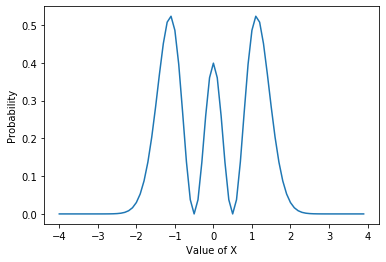

In [60]:
plt.plot(x, data)
plt.xlabel("Value of X")
plt.ylabel("Probability")

plt.show()

It works!

**Simulating Continuous-Variable QAOA For a Simple Problem** <div id="5"></div>

Now that we understand why QAOA/VQE actually work, let's try to implement a basic simulation of the algorithm for a basic cost function. Consider the horizontally translated parabloa:

<br><br>
$$f(x) \ = \ (x \ - \ a)^2$$
<br><br>

We can easily translate this to the language of "quantum cost Hamiltonians" with the method outlined in the previous section to get:

<br><br>
$$\hat{H}_{C} \ = \ (\hat{x} \ - \ a)^2$$
<br><br>

For our circuit, the unitary $U(\alpha, \ \gamma)$ is given as:

<br><br>
$$U(\alpha, \ \gamma) \ = \ e^{-i \alpha \hat{H}_{M}} e^{-i \gamma (\hat{x} \ - \ a)^2} \ \Rightarrow \ \hat{H}_{M} \ \in \ \{ \hat{H}_{K}, \ \hat{H}_{N} \}$$
<br><br>

In order to implement this on a photonic quantum circuit, we need to express these unitaries in terms of products of gates in the allowed gate set for our quantum computer. For our simulations, we will be using Strawberry Fields, so we are confined to the gate state that the Strawberry Fields library provides (we can technically make custom gates, but that feels like cheating). Anyways, let's expand and **separate**. Now, I hope you're saying (unless you're on step ahead of me): "Jack, separating a matrix exponential??? Don't you need an infinite number of terms for the Baker-Campbell-Hausdorff expansion???". Well, the answer is yes, but practically all of those terms end up being equal to one. The operators $\hat{x}^{n}$ and $\hat{x}^{m}$ will commute, thus Baker-Campbell-Hausdorff greatly reduces, ands we get:

<br><br>
$$e^{-i \gamma (\hat{x} \ - \ a)^2} \ = \ e^{-i \gamma (\hat{x}^2 \ - \ 2a\hat{x} \ + \ a^2)} \ = \ e^{-i \gamma \hat{x}^2} e^{i \gamma 2a \hat{x}} e^{-i \gamma a^2} \ \Rightarrow \ e^{-i \gamma \hat{x}^2} e^{i \gamma 2a \hat{x}}$$
<br><br>

We just dropped the exponential $e^{-i \gamma a^2}$ because it is an overall phase and does not affect our quantum state. Conceptually, this makes sense, as $a^2$ simply acts to shift our entire parabola vertically, not affecting the $x$-coordinate of the global minimum, thus we mught as well drop it from the cost function (we'll keep it in there for the classical post-processing). We have two gates that we need to act upon a photonic mode. In order to implement these unitaries on the quantum circuit, we express them as momentum displacement and quadratic phase operator. First, the momentum displacement operator is defined as:

<br><br>
$$Z(p) \ = \ \exp(i p \hat{x}/ \hbar)$$
<br><br>

So we then have:

<br><br>
$$e^{i \gamma 2a \hat{x}} \ \Rightarrow \ 2\gamma a \ = \ \frac{p}{\hbar} \ \Rightarrow \ p \ = \ 2 \gamma a \hbar$$
<br><br>

We also utilize the quadratic phase gate:

<br><br>
$$P(s) \ = \ \exp \Big( i \frac{s}{2\hbar} \hat{x}^2 \Big) \ \Rightarrow \ e^{-i \gamma \hat{x}^2} \ \Rightarrow \ -\gamma \ = \ \frac{s}{2\hbar} \ \Rightarrow \ s \ = \ -2 \gamma \hbar$$
<br><br>

We can code this up in Strawberry Fields! First, we have to initialize the value of Planck's constant, as well as the value of $a$. For now, we will pick some arbitrary value (I chose $0.83$). You can change this later, if you want to convince yourself that the algorithm works for other values of $a$ as well:

In [101]:
#Defines the value of h-bar

sf.hbar = 0.5
hbar = 0.5

#Defines the value of the parabolic minimum

parabolic_min = 0.83

We will now define our classical cost function, which is fairly easy in Python:

In [77]:
#Defines the classical cost function

def function_optimize(x, parabolic_min):
    y = (x - parabolic_min)**2
    return y

We now have to define our cost unitary, to be used in the QAOA process, which again, we can do fairly easily:

In [78]:
#Defines the cost unitary for QAOA

def cost_ham(q, p):

    Zgate(parabolic_min*2*hbar*p) | q[0]
    Pgate(-2*hbar*p) | q[0]

Now we can turn our attention to implementing the mixer Hamiltonian. Let's start with the kinetic mixer, then move to the number mixer. In order to implement this gate, we simply perform a Fourier gate-operation on both sides of the qudratic phase gate:

<br><br>
$$\exp \Big( i \frac{s}{2\hbar} \hat{p}^2 \Big) \ = \ \exp \Big( i \frac{s}{2\hbar} F^{\dagger} \hat{x} F F^{\dagger} \hat{x} F \Big) \ = \ \exp \Big( i \frac{s}{2\hbar} F^{\dagger} \hat{x}^2 F \Big) \ = \ \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{(i \frac{s}{2\hbar})^{i} (F^{\dagger} \hat{x}^2 F)^{i}}{i!} \ = \ F^{\dagger} \displaystyle\sum_{i \ = \ 0}^{\infty} \frac{(i \frac{s}{2\hbar})^{i} (\hat{x}^2)^{i} }{i!} F \ = \ F^{\dagger} P(s) F$$
<br><br>

If the removal of those Fourier operations from the sum made you do a double-take, never fear! Consider the following:

<br><br>
$$M N^n M^{-1} \ = \ M (N \mathbb{I})^n M^{-1} \ = \ M (N M^{-1} M)^n M^{-1} \ = \ (M N M^{-1})^n$$
<br><br>

Since $F^{\dagger}$ is the inverse of $F$, as these operations are unitary, the same logic follows. We can then code this into our Strawberry Fields program, with the parameter $s \ = \ -\frac{1}{2} \hbar \alpha$:

In [79]:
#Defines the kinetic mixer unitary for QAOA

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Pgate(-1*hbar*p) | q[0]
    Rgate(math.pi/2) | q[0]

    return q 

We have a few more parameters that we have to define as well before we run our simulation. We have to choose our circuit depth, which is the number of times the cost-mixer unitary is applied and the photon cutoff dimension for our Strawberry Fields simulation. In addition, we have to choose our **squeezing parameter**. We will be initializing our simulation in a squeezed state over the $x$-quadrature, in order to ensure that our algorithm searches over a large space of possible solutions:

In [93]:
#Defines the circuit depth, cutoff dimension, and the squeezing parameter

circuit_depth = 3
squeezing = -0.5
cutoff = 5

Now, we are in a position to define our first circuit, which will return numerical values for our graphical visualization. Note that this is not the function that we will be using for the actual optimization of the circuit, as this function does not sample the circuit, but rather returns Wigner function values for our graph.  We will find Wigner function values ranging from $-30$ to $30$, for both the $x$ and $p$ quadratures, with a spacing of $0.1$ between measured values. In addition, we will only optimize over one parameter, as the function we are optimizing is a fairly simple one:

In [94]:
#Defines the function used to run the circuit and return numerical data

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(1)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[0] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0, circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state
    a = state.wigner(0, [i/10 for i in range(-30, 30)], [i/10 for i in range(-30, 30)])
    return a

Next, we will define our "sampling function", which is identical to the one that we just provided, except instead of returning numerical Wigner function values, we will actually sample the circuit for individual values:

In [95]:
#Defines the sampling circuit simulation

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(1)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[0] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0,circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

        MeasureX | q[0]

    result = eng.run(prog)
    return result.samples[0]

We now have to specify how many times we will sample the circuit, to obtain a decently accurate value for the expectation value of our cost Hamiltonian. For now, we will choose $15$ as the number of our samples.

In [96]:
#Defines the number of iterations that the circuit is sampled

shots = 15

We now have to define our **objective function**, which is the function that we will attempt to optimize with our classical optimizer. As the cost, we will return the average of our repeated samples of the circuit:

In [97]:
#Defines the objective function that is minimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av
        calculation = function_optimize(result1, parabolic_min)
        costly = costly + calculation

    costly = costly/shots


    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

Next, we will define the actual classical optimizer that we will use to minimize the objective function. For this implementation, we will use the Nelder-Mead optimizer. For our initial parameter, we will choose a random value from $-3$  to $3$ (this was arbitrary, there is probably a better way to choose this initial parameter based on traditional gradient descent methods, but for now, a random value in this aarbitrary range will suffice). Finally, we will run our numerical circuit one more time with the optimal parameters, in order to get Wigner function values for our graphical visualization:

Paramter: [-0.97]
Value of Cost Function: 0.43513583550542007
Paramter: [-1.0185]
Value of Cost Function: 0.10466390018776067
Paramter: [-1.067]
Value of Cost Function: 0.28793846946881885
Paramter: [-1.04275]
Value of Cost Function: 0.07749277235325454
Paramter: [-1.067]
Value of Cost Function: 0.29722133474386286
Paramter: [-1.030625]
Value of Cost Function: 0.1406666464284185
Paramter: [-1.030625]
Value of Cost Function: 0.32884805827517055
Paramter: [-1.054875]
Value of Cost Function: 0.4038743309571217
Paramter: [-1.0366875]
Value of Cost Function: 0.14403148505285468
Paramter: [-1.0488125]
Value of Cost Function: 0.4279020773256463
Paramter: [-1.03971875]
Value of Cost Function: 0.1297114614271474
Paramter: [-1.04578125]
Value of Cost Function: 0.15324513427691774
Paramter: [-1.04123437]
Value of Cost Function: 0.3287606707487621
Paramter: [-1.04123437]
Value of Cost Function: 0.18736305537192782
Paramter: [-1.04426562]
Value of Cost Function: 0.32546063976980594
Paramter: [-1.04

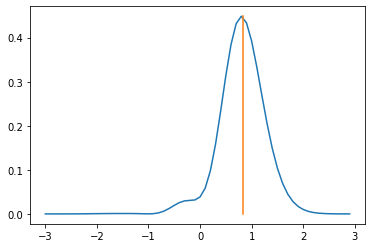

In [100]:
#Defines the optimizer that minimizes the objective function

out = minimize(objective, x0=[random.randint(-150,150)/100], method="Nelder-Mead", options={'maxiter':20})
print(out)

#Creates the graphical visualization

final = run_circuit(out['x'])

x = [i/10 for i in range(-30, 30)]
y = []


for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

plt.plot(x, y)
plt.plot([parabolic_min, parabolic_min, parabolic_min, parabolic_min, parabolic_min], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

plt.show()

So the optimizer performs decently well. As you can see, the $x$-quadrature has spiked pretty close to the optimal point, which is marked by the orange line!

You are welcome to play around further with other mixers, parameters, circuit depth, etc. to see what works the best before you proceed in this notebook, but for now, I'm going to move onto something a bit more interesting! For some reason, the optimizer does not do as well when $a$ is chosen outside the range of $-1$ to $1$, but this can be improved by playing around with the squeezing parameters, as well as the value of Planck's constant. For instance, let's increase the value of Planck's constant to one and try to run the simulation for a larger value of $a$ (I include the results as an image so I don't have to re-write all the code below). All other parameters were kept constant, except the value of Planck's constant, and the value of $a$, which is now $-1.41$:

<br>
<img src="image1.png" style="height:400px;">
<br>

As you can see, we get pretty decent results! It is important to note that when I was playing around with it, the optimizer was super finicky, and sometimes would not work. There are a lot of sources of error that could account for this, including limits in classical optimizers when sampling stochastic functions, low cutoff dimension, etc.

**Simulating Continuous-Variable QAOA For Harder Problems** <div id="6"></div>

Anyways, we have solved a very simple problem, but what if we want to solve something a bit more complex, like a question involving two variables? Well, we can implement that as well, but this time, we will have to use two optical modes instead of one, to encode both variables in our cost function. Let's try to minimize the function given by:

<br><br>
$$f(x, \ y) \ = \ (2x-y)^2 + (x-1)(y+1) \ = \ x^2 \ + \ y^2 \ + \ x \ + \ y \ + \ xy$$

$$\Rightarrow \ \min f(x, \ y) \ = \ -\frac{1}{3} \ \Rightarrow \ (x, \ y) \ = \ \Big( -\frac{1}{3}, \ -\frac{1}{3} \Big) \ \approx \ (-0.333333333, \ -0.333333333)$$
<br><br>

As far as more complex functions go, this one is fairly simple and "symetric" in terms of its minimum. We can put this in the form of our unitary:

<br><br>
$$U(\alpha, \ \gamma) \ = \ e^{-i\alpha \hat{H}_{M}} e^{-i \gamma (\hat{x}^2 \ + \ \hat{x}\hat{y} \ + \ \hat{x} \ + \ \hat{y}^2 \ + \ \hat{y})}$$
<br><br>

Since the position operators all commute, we can write this unitary as a series of exponentials, which we can translate to photonic gates. We have:

<br><br>
$$e^{-i \gamma (\hat{x}^2 \ + \ \hat{x}\hat{y} \ + \ \hat{x} \ + \ \hat{y}^2 \ + \ \hat{y})} \ = \ e^{-i \gamma \hat{x}^2} e^{-i \gamma \hat{x}\hat{y}} e^{-i \gamma \hat{x}} e^{-i \gamma \hat{y}^2} e^{-i \gamma \hat{y}}$$
<br><br>

And then, doing all of the necessary algebra, we find that we can represent this series of unitaries as photonic gates:

<br><br>
$$\Rightarrow \ e^{-i \gamma \hat{x}^2} \ = \ P_{1}(-2 \hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{x}\hat{y}} \ = \ CZ_{12}(-3 \hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{x}} \ = \ Z_{1}(-\hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{y}^2} \ = \ P_{2}(-2 \hbar \gamma)$$
<br>
$$\Rightarrow \ e^{-i \gamma \hat{y}} \ = \ Z_{2}(-\hbar\gamma)$$
<br>
$$U(\alpha, \ \gamma) \ = \ e^{-i\alpha \hat{H}_{M}} \ P_{1}(-2 \hbar \gamma) \ CZ_{12}(-3 \hbar \gamma) \ Z_{1}(-\hbar \gamma) \ P_{2}(-2 \hbar \gamma) \ Z_{2}(-\hbar\gamma)$$
<br><br>

Next, let's code this into our pre-existing simulation. We'll try both of the previous mixers in our simulations. Let's start with the kinetic mixer again, giving us a final unitary of:

<br><br>
$$U(\alpha, \ \gamma) \ = \ F^{\dagger}_{1} \ F^{\dagger}_{2} \ P_{1}(-\hbar\alpha) \ P_{2}(-\hbar\alpha) \ F_{1} \ F_{2} \ P_{1}(-2 \hbar \gamma) \ CZ_{12}(-3 \hbar \gamma) \ Z_{1}(-\hbar \gamma) \ P_{2}(-2 \hbar \gamma) \ Z_{2}(-\hbar\gamma)$$
<br><br>

Without further delay, let's code up our simulation! We have a new classical cost function that we have to implement first. In addition, we have define the value of Planck's constant:

In [190]:
#Defining the value of h-bar

sf.hbar = 0.5
hbar = 0.5

#Defining the classical cost function

def function_optimize(x1, x2):
    y = x1**2 + x2**2 + x1 + x2 + x1*x2
    return y

Next, we will have to define the new cost unitary, which we will be using in the QAOA procedure. This is fairly simple to do, as we have already come up with a gate-sequence that gives us our desired gate:

In [191]:
#Defining the cost unitary used in the QAOA procedure

def cost_ham(q, p):

    Zgate(-1**hbar*p) | q[1]
    Pgate(-2*hbar*p) | q[1]
    Zgate(-1*hbar*p) | q[0]
    Pgate(-2*hbar*p) | q[0]
    CZgate(-3*hbar*p) | (q[0], q[1])

    return q

We will also implement the kinetic mixer for two modes:

In [192]:
#Defining the mixer unitary used in the QAOA process

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Rgate(-1*math.pi/2) | q[1]

    Pgate(-1*hbar*p) | q[0]
    Pgate(-1*hbar*p) | q[1]

    Rgate(math.pi/2) | q[0]
    Rgate(math.pi/2) | q[1]

    return q

Just as we did before, we will assert the parameters that we will use to run our simulation. These parameters, like before, will be the squeezing parameter, the circuit depth, and the cutoff dimension:

In [198]:
#Defining circuit depth, cutoff dimension, and squeezing parameter

squeezing = -0.4
cutoff = 8
circuit_depth = 3

Once again, like we did before, we will define wo functions that run our circuit, one that returns numerical data for our visualizations, and one that samples the circuit. Again, we will optimize over only one parameter:

In [199]:
#Defining the function that simulates the circuit and returns results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state

    a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])
    b = state.wigner(1, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

    return [a, b]

#Defining the sampling circuit

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])


        MeasureX | q[0]
        MeasureX | q[1]

    result = eng.run(prog)
    return [result.samples[0], result.samples[1]]

We will choose our number of iterations, and specify the objective function:

In [200]:
#Define the number of iterations that should be sampled from the circuit

shots = 15

#Defining the objective function that is optimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av[0]
        result2 = av[1]
        calculation = function_optimize(result1, result2)
        costly = costly + calculation

    costly = costly/shots

    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

Then, we choose our optimizer once again. Finally, we can construct our visualizations, just as we did before. This time, we will examine a contour plot showing the probability of measuring a specific point $(x, \ y)$, as well as the quadratures showing the probability densities for the individual modes. It is important to note that the contour plot is not exact: since we passed the modes through a controlled-phase gate, they are no longer "independent", and thus, the probability of a particular measurement can't be determined by simply multiplying the individual probabilities of measurement. However, we can still get a decent approximation from the contour plot, so it is useful to examine as well:

Paramter: [-0.92 -0.73]
Value of Cost Function: 0.5713355408870178
Paramter: [ 0.08 -0.73]
Value of Cost Function: 2.5985616017388455
Paramter: [-0.92  0.27]
Value of Cost Function: 0.1254065636853998
Paramter: [-1.89665061  0.48483386]
Value of Cost Function: 0.7668995318806139
Paramter: [-0.48949667  0.52429684]
Value of Cost Function: 0.9983159216519352
Paramter: [-1.1653949   0.31776341]
Value of Cost Function: 0.44530958211377786
Paramter: [-0.8920057   0.02157231]
Value of Cost Function: -0.026378065058663313
Paramter: [-0.65922841 -0.06961286]
Value of Cost Function: 0.275405087907551
Paramter: [-1.00412325 -0.03369661]
Value of Cost Function: -0.13363035449372687
Paramter: [-1.08834697 -0.12606201]
Value of Cost Function: -0.05705895587341165
Paramter: [-1.08235807  0.06379346]
Value of Cost Function: 0.03548072024419
Paramter: [-0.94527083 -0.05473568]
Value of Cost Function: 0.004073661972832032
Paramter: [-1.02392954 -0.05786836]
Value of Cost Function: 0.12359246140353562
P

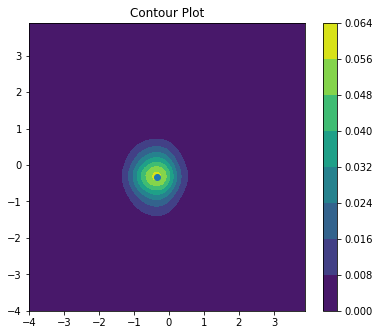

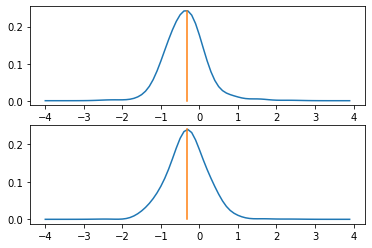

In [201]:
out = minimize(objective, x0=[random.randint(-100,100)/100, random.randint(-100,100)/100], method="COBYLA", options={'maxiter':20})
print("-----------------------------")
print(out)

#Define the y array for the first mode

f = run_circuit(out['x'])
final = f[0]

x = [i/10 for i in range(-40, 40)]
y = []

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

#Define the y array for the second mode

final2 = f[1]

x2 = [i/10 for i in range(-40, 40)]
y2 = []

for i in range(0, len(x2)):
    res = simps([final2[k][i] for k in range(0, len(x2))], x2)
    y2.append(res)


#Defines the contour plot that gives the final probability density function

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

x_vals = x
y_vals = x2
X, Y = np.meshgrid(x, x2)


Z = np.array([[i*j for i in y] for j in y2])

cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour Plot')
plt.scatter([float(-1)/3], [float(-1)/3])
plt.show()

#Defines the probability density graph of the first mode

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.plot([float(-1)/3 for o in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Defines the probability density graph of the second mode

plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.plot([float(-1)/3 for o in range(0, 5)], [0, 0.25*max(y2), 0.5*max(y2), 0.75*max(y2), max(y2)])

plt.show()

The blue dot on the contour graph corresponds to the optimal point. I really feel like I'm cheating with respect to this implementation, as I went through many different values of the parameters, like squeezing, cutoff dimension, and circuit depth to find this solution (which is really good)! For the most part, this example, when I ran it locally, was super volatile, and didn't work a lot of the time. I think it would be interesting to see an extension of this algorithm, where not only the unitaries are parametrized, but so are other parameters (like the squeezing parameter, cutoff dimension, and circuit depth). I would also hope that the algorithm performs better and more consistently when we are able to choose our initial parameters with an actual strategy rather than blinding picking some arbitrary set of numbers. Let's try another example, but this time, let's be a bit harder on ourselves and actually sample the function to obtain an optimal value (as one is supposed to do with an optimization algorithm)! Consider the function given as:

<br><br>
$$f(x, \ y) \ = \ 2x^2 \ + \ 2xy \ - \ 6x \ + \ 2y^2 \ - \ 5y \ + \ 10$$
<br>
$$\text{min} \ f(x, \ y) \ = \ \frac{29}{6} \ \Rightarrow \ (x, \ y) \ = \ \Big( \frac{7}{6}, \ \frac{2}{3} \Big)$$
<br><br>

Let's try optimizing this! For this function, since the distance between the optimal values of $x$ and $y$ is larger, we will st Planck's constant to $1$ to acheive larger variance without applying ridiculous amounts of squeezing (which can also mess up the simulation). By this point, you pretty much get the idea of how we implement the algorithm, so I won't go through all of it. Note that I am only re-defining the things that change, the rest will stay the same from the previous example:

Paramter: [ 0.34 -0.18]
Value of Cost Function: 9.307803654742312
Paramter: [ 1.34 -0.18]
Value of Cost Function: 10.515795116050741
Paramter: [0.34 0.82]
Value of Cost Function: 28.928896420635517
Paramter: [ 0.27855039 -1.17811019]
Value of Cost Function: 37.125205767336155
Paramter: [ 0.30927519 -0.67905509]
Value of Cost Function: 41.5589217202785
Paramter: [0.33533306 0.06995644]
Value of Cost Function: 16.852676606646867
Paramter: [ 0.21502178 -0.18233347]
Value of Cost Function: 7.986790860885201
Paramter: [ 0.13681649 -0.41978648]
Value of Cost Function: 23.035260031563766
Paramter: [ 0.19337873 -0.05922141]
Value of Cost Function: 7.228862372524561
Paramter: [ 0.13539445 -0.03589603]
Value of Cost Function: 9.914897524558999
Paramter: [ 0.25335664 -0.04164586]
Value of Cost Function: 13.561299903975282
Paramter: [ 0.18753864 -0.08992086]
Value of Cost Function: 7.016913767840332
Paramter: [ 0.20223573 -0.0952252 ]
Value of Cost Function: 6.42747954561483
Paramter: [ 0.21681059

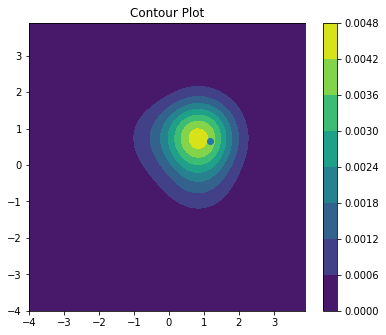

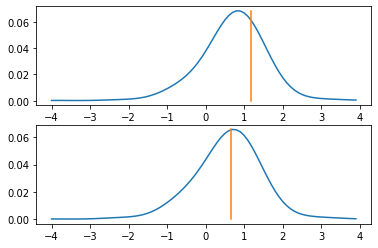

In [204]:
#Defining the value of h-bar

sf.hbar = 2
hbar = 2

#Defining the classical cost function

def function_optimize(x1, x2):
    y = 2*(x1**2) + 2*x1*x2 - 6*x1 + 2*(x2**2) - 5*x2 + 10
    return y

#Defining the cost unitary used in the QAOA procedure

def cost_ham(q, p):

    Zgate(5*hbar*p) | q[1]
    Pgate(-4*hbar*p) | q[1]
    Zgate(6*hbar*p) | q[0]
    Pgate(-4*hbar*p) | q[0]
    CZgate(-6*hbar*p) | (q[0], q[1])

    return q

#Defining the mixer unitary used in the QAOA process

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Rgate(-1*math.pi/2) | q[1]

    Pgate(-1*hbar*p) | q[0]
    Pgate(-1*hbar*p) | q[1]

    Rgate(math.pi/2) | q[0]
    Rgate(math.pi/2) | q[1]

    return q

#Defining circuit depth, cutoff dimension, and squeezing parameter

squeezing = -0.4
cutoff = 6
circuit_depth = 4

#Define the number of iterations that should be sampled from the circuit

shots = 15

#Defining the function that simulates the circuit and returns results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            if (i%2 == 0):
                cost_ham(q, param1[i])
                mixer_ham(q, param1[i])
            else:
                cost_ham(q, param2[i])
                mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state

    a = state.wigner(0, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])
    b = state.wigner(1, [i/10 for i in range(-40, 40)], [i/10 for i in range(-40, 40)])

    return [a, b]

#Defining the sampling circuit

def old_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]
        Squeezed(squeezing,0) | q[1]

        for i in range(0, circuit_depth):
            if (i%2 == 0):
                cost_ham(q, param1[i])
                mixer_ham(q, param1[i])
            else:
                cost_ham(q, param2[i])
                mixer_ham(q, param2[i])


        MeasureX | q[0]
        MeasureX | q[1]

    result = eng.run(prog)
    return [result.samples[0], result.samples[1]]

#Defining the objective function that is optimized

def objective(param):

    costly = 0

    for i in range(0, shots):

        av = old_circuit(param)
        result1 = av[0]
        result2 = av[1]
        calculation = function_optimize(result1, result2)
        costly = costly + calculation

    costly = costly/shots

    print("Paramter: "+str(param))
    print("Value of Cost Function: "+str(costly))

    return costly

#Define the optimizer that is used to find the optimal value of the objective function

out = minimize(objective, x0=[random.randint(-50,50)/100, random.randint(-50,50)/100], method="COBYLA", options={'maxiter':20})
print("-----------------------------")
print(out)

#Defines the sampling method that finds the exact optimal value
samples = 200

optimal_cost = math.inf
optimal_val = 0

for t in range(0, samples):
    final_function = old_circuit(out['x'])
    if (function_optimize(final_function[0], final_function[1]) < optimal_cost):
        optimal_val = final_function
        print(optimal_val)
        optimal_cost = function_optimize(final_function[0], final_function[1])

print("The Optimal Value Is: "+str(optimal_val))


#Define the y array for the first mode

f = run_circuit(out['x'])
final = f[0]

x = [i/10 for i in range(-40, 40)]
y = []

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

#Define the y array for the second mode

final2 = f[1]

x2 = [i/10 for i in range(-40, 40)]
y2 = []

for i in range(0, len(x2)):
    res = simps([final2[k][i] for k in range(0, len(x2))], x2)
    y2.append(res)


#Defines the contour plot that gives the final probability density function

fig = plt.figure(figsize=(6,5))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height])

x_vals = x
y_vals = x2
X, Y = np.meshgrid(x, x2)


Z = np.array([[i*j for i in y] for j in y2])

cp = plt.contourf(X, Y, Z)
plt.colorbar(cp)

ax.set_title('Contour Plot')
plt.scatter([float(7)/6], [float(2)/3])
plt.show()

#Defines the probability density graph of the first mode

plt.subplot(2, 1, 1)
plt.plot(x, y)
plt.plot([float(7)/6 for o in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Defines the probability density graph of the second mode

plt.subplot(2, 1, 2)
plt.plot(x2, y2)
plt.plot([float(2)/3 for o in range(0, 5)], [0, 0.25*max(y2), 0.5*max(y2), 0.75*max(y2), max(y2)])

plt.show()

So it's not awful, but it isn't amazing either. Even so, I still feel like I'm cheating because I'm still being super selective with the parameters. In addition, this implementation uses a new approach to applying the parameters, where two parameters are optimized, and applied to the circuit in both the mixer and cost unitaries on even and odd numbered iterations respectively. The algorithm does appear to favour a region fairly close to our optimal value, however, there is a lot of variance due to us setting Planck's constant to $2$.

**The Not-So Grand Finale: A Quartic Function With Two Global Minima** <div id="7"></div>

Now, for the grand finale! We will attempt to implement to apply CV QAOA to the optimization of a **quartic** function. However, before we do this, we need to take a bit of a detour, and discuss how the heck we are actually going to create a quartic phase gate.

**Another Small Tangent: Higher-Order Gate Decomposition** <div id="8"></div>

Now, you're probably thinking: "hold on one second....how are we supposed to deal with exponentials of $\hat{x}^4$?". Well, never fear, we actually have a method to decompose this gate exactly, using the research presented by Kalajdzievski and Arrazola in the paper "Exact gate decompositions for photonic quantum computing" (see references for a link to the paper). The paper is genius, if you're interested I **highly** reccomend at least quickly going through it), but we can essentially decompose our quartic gate into a product of a bunch of lower-order gates. I'm not going to go through the proofs/calculations, but, for even $N$, the paper arrives at the relation:

<br><br>
$$e^{i \alpha \hat{x}_k^N} \ = \ e^{2i \alpha \hat{p}_j \hat{x}_k^{N/2}} e^{i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{p}_j \hat{x}_k^{N/2}} e^{-i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{x}_j \hat{x}_k^{N/2}}$$
<br><br>

So for the case of $N \ = \ 4$, we get:

<br><br>
$$e^{i \alpha \hat{x}_k^4} \ = \ e^{2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{-i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{x}_j \hat{x}_k^{2}} \ = \ e^{2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{i \alpha \hat{x}_j^2} e^{-2i \alpha \hat{p}_j \hat{x}_k^{2}} e^{-i \alpha \hat{x}_j^2} F^{\dagger}_j e^{-2i \alpha \hat{p}_j \hat{x}_k^{2}} F_j$$
<br><br>

The paper also gives as an identity:

<br><br>
$$e^{i3\beta^2 t \hat{p}_k \hat{x}_j^2} \ = \ e^{i2\beta \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{-i \beta \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{-i2\beta \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{i \beta \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{i \beta^3 t \frac{3}{4} \hat{x}^3_j}$$
<br><br>
$$\Rightarrow \ e^{i3 t \hat{p}_k \hat{x}_j^2} \ = \ e^{i2 \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{-i \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{-i2 \hat{x}_j \hat{x}_k} e^{i t \hat{p}_k^3} e^{i \hat{x}_j \hat{x}_k} e^{-i t \hat{p}_k^3} e^{i t \frac{3}{4} \hat{x}^3_j} \ = \ e^{i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i t \hat{x}_k^3} F e^{-i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i t \hat{x}_k^3} F e^{-i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i t \hat{x}_k^3} F e^{i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i t \hat{x}_k^3} F e^{i t \frac{3}{4} \hat{x}^3_j}$$
<br><br>
$$\Rightarrow e^{i \omega \hat{p}_k \hat{x}_j^2} \ = \ e^{i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i \frac{\omega}{3} \hat{x}_k^3} F e^{-i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i \frac{\omega}{3} \hat{x}_k^3} F e^{-i2 \hat{x}_j \hat{x}_k} F^{\dagger} e^{-i \frac{\omega}{3} \hat{x}_k^3} F e^{i \hat{x}_j \hat{x}_k} F^{\dagger} e^{i \frac{\omega}{3} \hat{x}_k^3} F e^{i \frac{\omega}{4} \hat{x}^3_j}$$
<br><br>

So we have a method to implement gates of the form $e^{i \alpha \hat{p}_k \hat{x}_j^2}$, as well as gates of the form $e^{i \alpha \hat{x}_k \hat{x}_j^2}$ (all we have to do is use a couple Fourier gates). I know, it's a bit of a mess, but we'll break it down, and implement it into our simulation in chunks. We can start by creating a function that generates this specific gate:

In [211]:
#Implementing the sub-component gate involved in quartic decomposition

def crazy_gate(omega, q, selector):

    Vgate(0.25*3*hbar*omega) | q[selector+1]
    Rgate(math.pi/2) | q[selector]
    Vgate(hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(-1*hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(-2*hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(-1*hbar) | (q[selector], q[selector+1])
    Rgate(math.pi/2) | q[selector]
    Vgate(-1*hbar*omega) | q[selector]
    Rgate(-1*math.pi/2) | q[selector]
    CZgate(2*hbar) | (q[selector], q[selector+1])
    
    return q

We can then construct a function that returns the quartic gate:

In [212]:
#Defining the quartic gate, in terms of a decomposition

def quartic_gate(q, alpha, selector):

    Rgate(math.pi/2) | q[selector+1]
    crazy_gate(-2*alpha, q, selector)
    Rgate(math.pi/2) | q[selector+1]
    Pgate(-2*hbar*alpha) | q[selector+1]
    crazy_gate(-2*alpha, q, selector)
    Pgate(2*hbar*alpha) | q[selector+1]
    crazy_gate(2*alpha, q, selector)

And that concludes our small detour! Now, let us turn our attention to the function that we wish to optimize, which is:

<br><br>
$$f(x, \ y) \ = \ 0.5x^4 \ - \ 8x^2$$
<br>
$$\text{min} \ f(x, \ y) \ = \ -32 \ \Rightarrow \ x \ = \ \pm \ 2 \sqrt{2}$$
<br><br>

Excellent, so we can now implement our simulation one more time. As usual, we first have to define our value of Planck's constant, ass well as our classical cost function, which will be given as:

In [224]:
#Defining the value of h-bar

sf.hbar = 1
hbar = 1

#Defining the classical cost function that we are trying to optimize

def function_optimize(x1):
    y = 0.5*(x1**4) - 8*(x1**2)
    return y

Next, we define our cost and mixer unitaries:

In [225]:
#Defining the cost unitary to be used in QAOA

def cost_ham(q, p):

    quartic_gate(q, -0.5, 0)
    Pgate(16*hbar*p) | q[0]

#Defining the kinetic mixer unitary to be used in QAOA

def mixer_ham(q, p):

    Rgate(-1*math.pi/2) | q[0]
    Pgate(-1*hbar*p) | q[0]
    Rgate(math.pi/2) | q[0]

    return q

We then define our parameters, and our numerical circuit simulator:

In [226]:
#Defining the depth of the QAOA circuit to be constructed, the squeezing parameter, and the cutoff dimension

circuit_depth = 10
squeezing = -0.5
cutoff = 7


# Defining the function that simulates the circuit, and returns the results

def run_circuit(param):

    eng = sf.Engine("fock", backend_options={"cutoff_dim":cutoff})
    prog = sf.Program(2)

    param1 = [param[0] for i in range(0, circuit_depth)]
    param2 = [param[1] for i in range(0, circuit_depth)]

    with prog.context as q:

        Squeezed(squeezing,0) | q[0]

        for i in range(0, circuit_depth):

            cost_ham(q, param1[i])
            mixer_ham(q, param2[i])

    state = eng.run(prog, run_options={"eval": False}).state
    a = state.wigner(0, [i/100 for i in range(-500, 500)], [i/100 for i in range(-500,500)])

    return a

Now here is where things get interesting.........

**I Promise This is Our Last Detour: Numerically Calculating the Cost Hamiltonian Expectation Value** <div id="9"></div>

The next step of our simulation should be to define our objective function, which we will minimize. Usually we would od this through finite sampling, but in thi case, we will try something new.

Our cost Hamiltonian is of the form:

<br><br>
$$H_{C} \ = \ \hat{x}^4 \ - \ 8\hat{x}^2$$
<br><br>

Thus, when QAOA terminates for each iteration, we want to find, for the prepared state vector $|s\rangle$:

<br><br>
$$\langle H_{C} \rangle \ = \ \langle s | 0.5\hat{x}^4 \ - \ 8\hat{x}^2 | s \rangle$$
<br><br>

Usually, we would have to sample the circuit repeatedly to obtain this expectation value. However, we're going to be sneaky for this simulation, because sampling a circuit this deep will take a nightmarishly long time (not really, but I'm super impatient). We have:

<br><br>
$$\langle s | 0.5\hat{x}^4 \ - \ 8\hat{x}^2 | s \rangle \ = \ 0.5 \langle s | \hat{x}^4 | s \rangle \ - \ 8 \langle s |\hat{x}^2 | s\rangle \ = \  0.5 \displaystyle\int \langle s | x \rangle \langle x | dx \ \hat{x}^4 \displaystyle\int |y \rangle \langle y | s \rangle dy \ - \ 8 \displaystyle\int \langle s | x \rangle \langle x | dx \ \hat{x}^2 \displaystyle\int | y \rangle \langle y | s\rangle dy$$
<br>
$$\Rightarrow \ 0.5 \displaystyle\int \displaystyle\int x^4 \langle s | x \rangle \langle x |y \rangle \langle y | s \rangle \ dy \ dx \ - \ 8 \displaystyle\int \displaystyle\int x^2 \langle s | x \rangle \langle x |y \rangle \langle y | s\rangle \ dy \ dx \ = \ 0.5 \displaystyle\int x^4 \langle s | x \rangle \langle x | s \rangle \ dx \ - \ 8 \displaystyle\int x^2 \langle s | x \rangle \langle x | s \rangle \ dx$$
<br>
$$\Rightarrow \ 0.5 \displaystyle\int x^4 |\langle x | s \rangle|^2 \ dx \ - \ 8 \displaystyle\int x^2 |\langle x | s \rangle|^2 \ dx$$
<br><br>

This tells us something very useful. Essentially, we already know $|\langle x | s \rangle|^2$, this is just the $x$-quadrature probability values. We also already know how to integrate over it numerically, thus, while we take this integral, we simply have multiply either $x^2$ or $x^4$ inside the integrand, and then put the obtained values back into this formula to get the expectation value of the cost Hamiltonian by only evaluating the circuit once! This, technically, is cheating, but we are just experimenting, so I'm going to accept that this is allowed.

Based on what we have just found, we define our new, **numerical** objective function:

In [227]:
#Defining the objective function that will be minimized by the optimizer

def new_objective(param):

    av = run_circuit(param)

    y = []
    x = [i/100 for i in range(-500, 500)]
    for i in range(0, len(x)):
        res = simps([av[k][i] for k in range(0, len(x))], x)
        y.append(res)

    norm_factor = simps(y, x)
    y = [y[i]/norm_factor for i in range(0, len(y))]

    first_x_2 = [(x[i]**2)*y[i] for i in range(0, len(x))]
    first_x_4 = [(x[i]**4)*y[i] for i in range(0, len(x))]

    i2 = simps(first_x_2, x)
    i3 = simps(first_x_4, x)

    calculation = 0.5*i3 - 8*i2

    print("Value of Cost Function: "+str(calculation))

    return calculation

As you can see, we run the numerical circuit simulator once, and integrate to get expectation values for $x^4$ and $x^2$. You should also notice that we normalize our data points before integrating. This is just due to quartic gates leading to highly unnormalized final states, with ridiculously small values as data points. This leads to Python occasionally getting confused, and thinking it is dividing by $0$ (yes, the probabilities get that small). To get around this issue, we simply normalize the data before we calculate the expectation values.

Finally, we define our optimizer and our visualization:

Value of Cost Function: -14.734068693168158
Value of Cost Function: -17.930193380724567
Value of Cost Function: -20.093765483118634
Value of Cost Function: -18.698065406581467
Value of Cost Function: -15.811369770776526
Value of Cost Function: -18.995351697864237
Value of Cost Function: -19.847406828613828
Value of Cost Function: -21.312945562458165
Value of Cost Function: -18.902524037664346
Value of Cost Function: -21.251191041874723
Value of Cost Function: -20.091239240508703
Value of Cost Function: -20.595074750185233
Value of Cost Function: -21.417078158874855
Value of Cost Function: -20.824062080423104
Value of Cost Function: -21.39646803297549
Value of Cost Function: -20.895055242608997
Value of Cost Function: -21.200454402697652
Value of Cost Function: -21.480567520829833
Value of Cost Function: -21.48280024797965
Value of Cost Function: -21.48828950990507
     fun: -21.48828950990507
   maxcv: 0.0
 message: 'Maximum number of function evaluations has been exceeded.'
    nfev: 

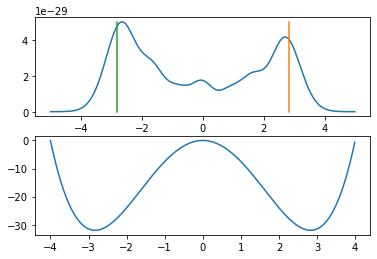

In [228]:
#Define the optimizer that is used to find the optimal value of the cost function

out = minimize(new_objective, x0=[random.randint(-500,500)/100, random.randint(-500,500)/100], method="COBYLA", options={'maxiter':20})
print(out)

#Runs the circuit a final time, with the optimal parameters

final = run_circuit(out['x'])

#Define the arrays used for the graphical visualization

x = [i/100 for i in range(-500, 500)]
x2 = [i/100 for i in range(-400, 400)]
y = []

#Construct the quadrature graph

for i in range(0, len(x)):
    res = simps([final[k][i] for k in range(0, len(x))], x)
    y.append(res)

plt.subplot(2, 1, 1)
plt.plot(x, y)

#Plot vertical lines corresponding to the actual optimal solutions

plt.plot([2*math.sqrt(2) for i in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])
plt.plot([-2*math.sqrt(2) for i in range(0, 5)], [0, 0.25*max(y), 0.5*max(y), 0.75*max(y), max(y)])

#Plot the actual cost function itself

plt.subplot(2, 1, 2)
plt.plot(x2, [function_optimize(x2[i]) for i in range(0, len(x2))])

plt.show()

So we get pretty great results, with two "spikes" appearing at the minima of the cost function. This simulation, however, required a very deep circuit (depth of $8$), so there is definitely a trade-off that must be considered, between accuracy of the algorithms, and dpeth of the circuit (which on a real quantum computer, would lead to loss of coherence).

**Conclusion** <div id="10"></div>

In conclusion, this notebook was meant to act as expository material, to give the reader an idea of what QAOA and CV QAOA are all about through some interesting physical theory in the first section, and concrete simulations in the second part. I really hope you, the reader, has gained more clarity about the power of an algorithm like QAOA (specifically CV QAOA)!

To address to topic of the accuracy of these simulations, I feel like for a lot of these results, I kind of got lucky. When I ran tests locally, I got a lot of great results, but at the same time, I got a lot of not-so-great results. I also feel as though I am "selecting" ideal parameters for each of the simulations, as a lot of the squeezing parameters, cutoff dimensions, etc. that I tested (which I didn't include in this notebook), did not work very well. Nevertheless, I think this is an interesting starting point to dive further into CV QAOA and conceptualize better training techniques, and more general ways to choose parameters such that convergence of the algorithm can be ensured to a higher degree.

**Acknowledgements** <div id="11"></div>

This notebook would not have been compelted without all the help of Guillaume Verdon, Josh Izaac, Nicolas Quesada, Juan Miguel Arrazola, and Nathan Killoran. Thank you to all of you guys, I really appreciate that you took the time to answer my never-ending stream of questions!

**References**

Original CV QAOA Paper: [https://arxiv.org/abs/1902.00409](https://arxiv.org/abs/1902.00409)
<br>
CV Gate Decomposition Paper: [https://arxiv.org/abs/1811.10651](https://arxiv.org/abs/1811.10651)
<br>
The Code for the Contour Graph was Based Off of a StackExchange Answer (Will Update With Link)
<br>
Gaussian Quantum Information: [https://arxiv.org/abs/1110.3234](https://arxiv.org/abs/1110.3234)
<br>
Original QAOA Paper: [https://arxiv.org/abs/1411.4028](https://arxiv.org/abs/1411.4028)
<br>
Basic Explanation of QAE For QC: [https://quantumcomputing.stackexchange.com/a/5572/4907](https://quantumcomputing.stackexchange.com/a/5572/4907)